In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [190]:
# Function to calculate the precision of knn label predictions for the k nearest neighbors
def precision_at_k(knn_indices, cluster_labels, k):
    precision_scores = []
    for i, neighbors in enumerate(knn_indices):
        true_label = cluster_labels[i]
        retrieved_labels = [cluster_labels[j] for j in neighbors[1:k+1]]  
        relevant_count = sum(1 for label in retrieved_labels if label == true_label)
        precision_scores.append(relevant_count / k)
    return sum(precision_scores) / len(precision_scores)

### Method on Shot Data

In [447]:
shot_data = pd.read_csv("shot_data_with_poiu.csv")

In [448]:
shot_data = shot_data[shot_data.situation == '5on5']

In [449]:
offense_cols = [
    'shooting_poiu_id', 'xGoal', 'goal','shotDistance',
     'shotWasOnGoal'
]

defense_cols = [
    'defending_poiu_id', 'xGoal', 'goal', 'shotDistance',
    'shotWasOnGoal',
]

df_encoded = pd.get_dummies(shot_data, columns=['shotType'])

offensive_stats = (
    df_encoded[offense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['shooting_poiu_id'])
    .agg(['mean', 'sum']) 
)

defensive_stats = (
    df_encoded[defense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['defending_poiu_id'])
    .agg(['mean', 'sum'])
)

In [450]:
offensive_stats.columns = [f"{col[0]}_{col[1]}" for col in offensive_stats.columns]
offensive_stats['num_shots'] = shot_data.groupby('shooting_poiu_id').size()
offensive_stats.reset_index(inplace=True)

defensive_stats.columns = [f"{col[0]}_{col[1]}" for col in defensive_stats.columns]
defensive_stats['num_shots'] = shot_data.groupby('defending_poiu_id').size()
defensive_stats.reset_index(inplace=True)


In [451]:
offensive_stats.rename(columns={"shooting_poiu_id": "poiu_id"}, inplace=True)
defensive_stats.rename(columns={"defending_poiu_id": "poiu_id"}, inplace=True)


In [452]:
merged_df = pd.merge(
    offensive_stats, defensive_stats, 
    on = "poiu_id",
    how="outer", suffixes=('_offense', '_defense'))
merged_df.fillna(0, inplace=True)

In [453]:
merged_df["corsi"] = merged_df["num_shots_offense"] - merged_df["num_shots_defense"]

In [464]:
merged_df["total_shots"] = merged_df["num_shots_defense"] + merged_df["num_shots_offense"]

In [477]:
filtered_df = merged_df[merged_df.total_shots > 1]

In [478]:
cols = list(merged_df.columns)
cols = [col for col in cols if col not in ["poiu_id", "total_shots"]]

In [496]:
poiu_ids = merged_df['poiu_id']

In [488]:
X = merged_df[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

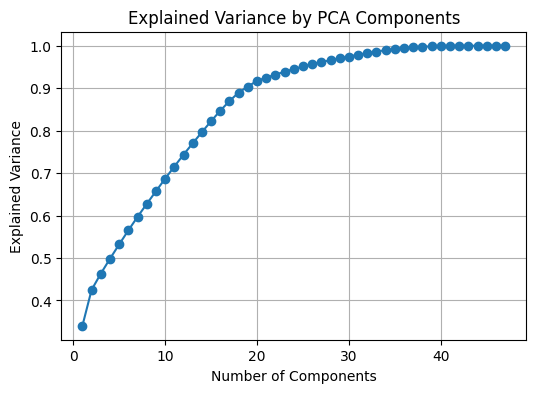

In [489]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

In [490]:
pca = PCA(n_components=19)
X_reduced = pca.fit_transform(X_scaled)

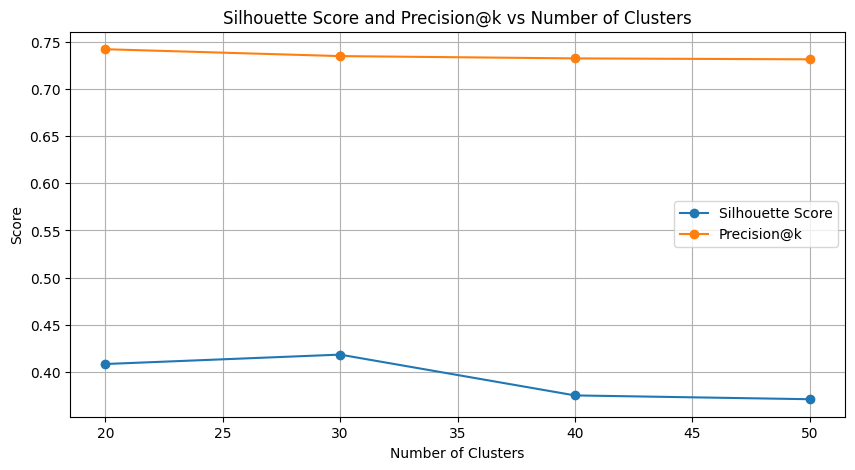

In [492]:
sil_scores = []
prec_at_k_scores = []
k_values = np.arange(20,51,10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=5)
    cluster_labels = kmeans.fit_predict(X_reduced)

    sil = silhouette_score(X_scaled, cluster_labels, metric="cosine")
    sil_scores.append(sil)

    knn = NearestNeighbors(n_neighbors=5, metric="cosine")
    knn.fit(X_scaled)
    _, indices = knn.kneighbors(X_scaled)

    prec_k = precision_at_k(indices, cluster_labels, k=5)
    prec_at_k_scores.append(prec_k)

plt.figure(figsize=(10, 5))
plt.plot(k_values, sil_scores, label="Silhouette Score", marker='o')
plt.plot(k_values, prec_at_k_scores, label="Precision@k", marker='o')
plt.title("Silhouette Score and Precision@k vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [494]:
prec_at_k_scores

[0.7423206353479608,
 0.7350293893301028,
 0.7325840175887288,
 0.7315968950509265]

In [497]:
knn = NearestNeighbors(n_neighbors=6, metric='cosine') 
knn.fit(X_reduced)
distances, indices = knn.kneighbors(X_reduced)

poiu_similarity_dict = {}

for i in range(len(poiu_ids)):
    neighbors = []
    for j in range(1,6): 
        neighbor_index = indices[i][j]
        neighbor_id = poiu_ids.iloc[neighbor_index]
        similarity = 1 - distances[i][j]
        similarity_pct = round(similarity * 100, 2)
        neighbors.append({'poiu_id': neighbor_id, 'similarity_pct': similarity_pct})
    
    poiu_similarity_dict[poiu_ids.iloc[i]] = neighbors

In [498]:
rows = []

for main_id, neighbors in poiu_similarity_dict.items():
    row = {'poiu_id': main_id}
    for idx, neighbor in enumerate(neighbors, start=1):
        row[f'neighbor_{idx}'] = neighbor['poiu_id']
        row[f'similarity_{idx}'] = neighbor['similarity_pct']
    rows.append(row)

poiu_neighbors_df = pd.DataFrame(rows)

In [499]:
poiu_neighbors_df

,poiu_id,neighbor_1,similarity_1,neighbor_2,similarity_2,neighbor_3,similarity_3,neighbor_4,similarity_4,neighbor_5,similarity_5
0,6649,46314,99.61,69548,99.45,50579,99.28,28909,99.26,27716,99.23
1,6650,46514,89.22,62140,87.25,45429,86.87,10185,86.54,61340,86.46
2,6651,61848,97.25,32737,95.85,44912,95.66,44822,95.13,9824,95.00
3,6652,54517,98.56,40543,98.55,36337,97.83,63840,97.80,28769,97.53
4,6653,11748,98.77,10107,98.77,10852,98.46,12263,98.36,7692,98.24
...,...,...,...,...,...,...,...,...,...,...,...
44569,71070,43030,100.00,34754,100.00,70645,100.00,67506,100.00,65613,100.00
44570,71071,24061,99.90,58079,99.89,30382,99.67,12885,99.19,63672,98.81
44571,71072,30023,100.00,57483,100.00,15982,100.00,52160,100.00,37931,100.00
44572,71073,24428,100.00,21823,100.00,35580,100.00,27340,100.00,42439,100.00


In [500]:
poiu_neighbors_df.to_csv('similarity_2023.csv', index=False)

### Method on MoneyPuck Data

In [ ]:
lines = pd.read_csv("lines.csv")

In [313]:
feature_columns = [
    "xGoalsPercentage", "corsiPercentage", "fenwickPercentage", "xOnGoalFor",
    "xGoalsFor", "shotsOnGoalFor", "blockedShotAttemptsFor", "hitsFor", 
    "takeawaysFor", "giveawaysFor"
]

In [ ]:
# Filter the lines to used features and scale the dataframe
X = lines[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Baseline values of 5 clusters/neighbors more testing needed
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X_scaled)  

num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors+1, metric='cosine') # use cosine similarity to "normalize" data
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)

# Get the KNN label for each line combination and add to list
knn_labels = []
for i in range(len(lines)):
    knn_labels.append(cluster_labels[indices[i][0]])  

# Calculate silhoutte score from KNN
silhouette_knn = silhouette_score(X_scaled, knn_labels, metric="cosine")

#Calculate precision at k (function above)
precision_k = precision_at_k(indices, cluster_labels, num_neighbors)

print(silhouette_knn)
print(precision_k)

0.4444131485608894
0.9182496607869742


In [ ]:
# Finds the five most similar lines for each line and store in dictionary
similar_lines = {lines["lineId"].iloc[i]: list(lines["lineId"].iloc[indices[i][1:]]) for i in range(len(lines))}

num_lines = 0

# Print a few example similar lines
for line, similar in similar_lines.items():
    if num_lines < 5:
        print(f"Main Line")
        print(f"Players: {lines[lines["lineId"]==line].name.values[0]}")
        for sim in similar:
            print(f"    Similar Line")
            print(f"    Players: {lines[lines["lineId"]==sim].name.values[0]}")
        num_lines+= 1

Main Line
Players: Luostarinen-Lundell-Reinhart
    Similar Line
    Players: Necas-Drury-Noesen
    Similar Line
    Players: Bratt-Toffoli-Hughes
    Similar Line
    Players: Bertuzzi-Matthews-Domi
    Similar Line
    Players: Forsling-Montour
    Similar Line
    Players: Guentzel-Aho-Jarvis
Main Line
Players: Lindell-Hakanp
    Similar Line
    Players: Romanov-Dobson
    Similar Line
    Players: Dahlin-Samuelsson
    Similar Line
    Players: York-Sanheim
    Similar Line
    Players: Valimaki-Kesselring
    Similar Line
    Players: Gostisbehere-Maatta
Main Line
Players: Kunin-Granlund-Zadina
    Similar Line
    Players: Girgensons-Cozens-Okposo
    Similar Line
    Players: Eklund-Bordeleau-Hoffman
    Similar Line
    Players: Hirose-Juulsen
    Similar Line
    Players: Pyyhtia-Danforth-Olivier
    Similar Line
    Players: Zetterlund-Sturm-Hoffman
Main Line
Players: Krug-Leddy
    Similar Line
    Players: Lacombe-Lyubushkin
    Similar Line
    Players: Kubalik-Ostapchuk

### Similarity Merged MoneyPuck Data

In [287]:
lines_merged = pd.read_csv("linesMerged.csv")


In [430]:
X = lines_merged[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [432]:
# Baseline values of 5 clusters/neighbors more testing needed
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(X_scaled)  

num_neighbors = 5
knn = NearestNeighbors(n_neighbors=num_neighbors+1, metric='cosine') # use cosine similarity to "normalize" data
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)

# Get the KNN label for each line combination and add to list
knn_labels = []
for i in range(len(lines_merged)):
    knn_labels.append(cluster_labels[indices[i][0]])  

# Calculate silhoutte score from KNN
silhouette_knn = silhouette_score(X_scaled, knn_labels, metric="cosine")

#Calculate precision at k (function above)
precision_k = precision_at_k(indices, cluster_labels, num_neighbors)

print(silhouette_knn)
print(precision_k)

0.22420530737938388
0.9350764134726333


In [433]:
# Finds the five most similar lines for each line and store in dictionary
similar_lines = {lines_merged["lineId"].iloc[i]: list(lines_merged["lineId"].iloc[indices[i][1:]]) for i in range(len(lines))}

num_lines = 0

# Print a few example similar lines
for line, similar in similar_lines.items():
    if num_lines < 5:
        print(f"Main Line")
        print(f"Players: {lines_merged[lines_merged["lineId"]==line].name.values[0]}")
        for sim in similar:
            print(f"    Similar Line")
            print(f"    Players: {lines_merged[lines_merged["lineId"]==sim].name.values[0]}")
        num_lines+= 1

KeyError: 'lineId'

### Merge Data Together

In [343]:
lines = pd.read_csv("lines.csv")

In [344]:
lines = lines[lines.situation=='5on5']

In [345]:
d_lines = lines[lines.position == "pairing"].copy()
o_lines = lines[lines.position == "line"].copy()

In [346]:
o_lines.loc[:,'lineId'] = o_lines['lineId'].astype(str)
o_lines.loc[:,'player1_id'] = o_lines['lineId'].str[0:7].astype(int)
o_lines.loc[:,'player2_id'] = o_lines['lineId'].str[7:14].astype(int)
o_lines.loc[:,'player3_id'] = o_lines['lineId'].str[14:21].astype(int)

d_lines.loc[:,'lineId'] = d_lines['lineId'].astype(str)
d_lines.loc[:,'player1_id'] = d_lines['lineId'].str[0:7].astype(int)
d_lines.loc[:,'player2_id'] = d_lines['lineId'].str[7:14].astype(int)

In [401]:
shot_data = pd.read_csv("shot_data_with_poiu.csv")
shot_data = shot_data[shot_data.situation == '5on5']

In [402]:
shot_data["player_one_id"] = shot_data.player_one_id.astype(int)
shot_data["player_two_id"] = shot_data.player_two_id.astype(int)
shot_data["player_three_id"] = shot_data.player_three_id.astype(int)
shot_data["player_four_id"] = shot_data.player_four_id.astype(int)
shot_data["player_five_id"] = shot_data.player_five_id.astype(int)
shot_data["player_one_id.1"] = shot_data["player_one_id.1"].astype(int)
shot_data["player_two_id.1"] = shot_data["player_two_id.1"].astype(int)
shot_data["player_three_id.1"] = shot_data["player_three_id.1"].astype(int)
shot_data["player_four_id.1"] = shot_data["player_four_id.1"].astype(int)
shot_data["player_five_id.1"] = shot_data["player_five_id.1"].astype(int)

In [403]:
shot_data['offense_set'] = shot_data[['player_one_id', 'player_two_id', 'player_three_id', "player_four_id", "player_five_id"]].apply(
    lambda row: tuple(sorted([row['player_one_id'], row['player_two_id'], row['player_three_id'], row["player_four_id"], row["player_five_id"]])),
    axis=1
)

shot_data['defense_set'] = shot_data[['player_one_id.1', 'player_two_id.1', 'player_three_id.1', "player_four_id.1", "player_five_id.1"]].apply(
    lambda row: tuple(sorted([row['player_one_id.1'], row['player_two_id.1'], row['player_three_id.1'], row["player_four_id.1"], row["player_five_id.1"]])),
    axis=1
)

In [404]:
o_lines['forward_set'] = o_lines[['player1_id', 'player2_id', 'player3_id']].apply(
    lambda row: tuple(sorted([row['player1_id'], row['player2_id'], row['player3_id']])),
    axis=1
)
d_lines['defense_set'] = d_lines[['player1_id', 'player2_id']].apply(
    lambda row: tuple(sorted([row['player1_id'], row['player2_id']])),
    axis=1
)

In [405]:
feature_columns = [
    "xGoalsPercentage", "corsiPercentage", "fenwickPercentage", "xOnGoalFor",
    "xGoalsFor", "shotsOnGoalFor", "blockedShotAttemptsFor", "hitsFor", 
    "takeawaysFor", "giveawaysFor"
]
id_columns = ["player1_id", "player2_id", "player3_id", "forward_set"]
id_columns_def = ["player1_id", "player2_id", "defense_set"]

In [406]:
o_lines = o_lines[feature_columns + id_columns].copy()
d_lines = d_lines[feature_columns + id_columns_def].copy()

In [407]:
offense_cols = [
    'shooting_poiu_id', 'xGoal', 'goal','shotDistance',"offense_set",
    'shotRebound', 'shotRush', 'shotWasOnGoal'
]

defense_cols = [
    'defending_poiu_id', 'xGoal', 'goal', 'shotDistance',"defense_set",
    'shotRebound', 'shotRush','shotWasOnGoal',
]

df_encoded = pd.get_dummies(shot_data, columns=['shotType'])

offensive_stats = (
    df_encoded[offense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['shooting_poiu_id', "offense_set"])
    .agg(['mean', 'sum']) 
)

defensive_stats = (
    df_encoded[defense_cols + [col for col in df_encoded.columns if col.startswith('shotType_')]]
    .groupby(['defending_poiu_id', "defense_set"])
    .agg(['mean', 'sum'])
)

In [408]:
offensive_stats.columns = [f"{col[0]}_{col[1]}" for col in offensive_stats.columns]
offensive_stats['num_shots'] = shot_data.groupby('shooting_poiu_id').size()
offensive_stats.reset_index(inplace=True)

defensive_stats.columns = [f"{col[0]}_{col[1]}" for col in defensive_stats.columns]
defensive_stats['num_shots'] = shot_data.groupby('defending_poiu_id').size()
defensive_stats.reset_index(inplace=True)


In [409]:
offensive_stats.rename(columns={"shooting_poiu_id": "poiu_id"}, inplace=True)
defensive_stats.rename(columns={"defending_poiu_id": "poiu_id"}, inplace=True)


In [410]:
merged_df = pd.merge(
    offensive_stats, defensive_stats, 
    on = "poiu_id",
    how="outer", suffixes=('_offense', '_defense'))
merged_df.fillna(0, inplace=True)

In [412]:
merged_df["corsi"] = merged_df["num_shots_offense"] - merged_df["num_shots_defense"]

In [420]:
o_lines

,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,shotsOnGoalFor,blockedShotAttemptsFor,hitsFor,takeawaysFor,giveawaysFor,player1_id,player2_id,player3_id,forward_set
0,0.60,0.58,0.58,72.48,5.84,60.0,48.0,48.0,18.0,24.0,8477933,8480185,8482113,"(8477933, 8480185, 8482113)"
2,0.25,0.32,0.31,7.08,0.40,6.0,4.0,8.0,0.0,1.0,8475798,8479316,8480821,"(8475798, 8479316, 8480821)"
4,0.34,0.55,0.51,25.56,1.99,26.0,19.0,10.0,8.0,5.0,8477939,8478483,8479318,"(8477939, 8478483, 8479318)"
5,0.47,0.45,0.52,7.95,0.73,7.0,2.0,4.0,1.0,3.0,8475958,8481656,8482148,"(8475958, 8481656, 8482148)"
8,0.61,0.60,0.60,14.57,0.96,14.0,10.0,21.0,2.0,4.0,8478211,8478421,8479291,"(8478211, 8478421, 8479291)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,0.23,0.42,0.33,4.53,0.20,5.0,4.0,12.0,1.0,1.0,8477073,8477931,8482125,"(8477073, 8477931, 8482125)"
2940,0.67,0.62,0.63,342.45,34.47,336.0,155.0,154.0,61.0,79.0,8475786,8476454,8478402,"(8475786, 8476454, 8478402)"
2942,0.50,0.52,0.50,6.54,0.42,8.0,7.0,11.0,0.0,4.0,8478133,8479543,8481093,"(8478133, 8479543, 8481093)"
2945,0.13,0.15,0.14,2.16,0.10,2.0,1.0,11.0,1.0,2.0,8478046,8480003,8483505,"(8478046, 8480003, 8483505)"


In [429]:
offense_matches = []
defense_matches = []

for idx, row in merged_df.iterrows():
    row_players = row['offense_set']
    
    matching_o = o_lines[o_lines['forward_set'].apply(lambda s: set(s).issubset(row_players))]
    if not matching_o.empty:
        offense_data = matching_o.iloc[0].drop(['player1_id', 'player2_id', 'player3_id', 'forward_set'])
        offense_matches.append(offense_data)
    else:
        offense_matches.append(pd.Series(index=o_lines.columns.drop(['player1_id', 'player2_id', 'player3_id', 'forward_set'])))

    matching_d = d_lines[d_lines['defense_set'].apply(lambda s: set(s).issubset(row_players))]
    if not matching_d.empty:
        defense_data = matching_d.iloc[0].drop(['player1_id', 'player2_id', 'defense_set'])
        defense_matches.append(defense_data)
    else:
        defense_matches.append(pd.Series(index=d_lines.columns.drop(['player1_id', 'player2_id', 'defense_set'])))

TypeError: 'int' object is not iterable

In [ ]:
set(o_lines.forward_set.values[0])

{np.int64(8477933), np.int64(8480185), np.int64(8482113)}